# Multichannel Image Reconstruction with Noise
Objectives:
1. Show effect of noise in multichannel images (RMS and SENSE)
1. Provide a template for noise measurement


## Generate Image Data and Coil Sensitivities
The image here is a simple array of shapes.  Coil sensitivities are 2D gaussian, for simplicity.

Start
cims pixel [8.62010300e-01+0.j 2.68373685e-03+0.j 2.23644753e-03+0.j
 1.54729678e-05+0.j]


/Users/brian/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


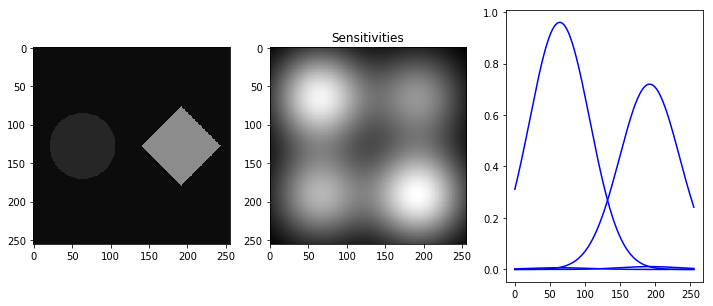

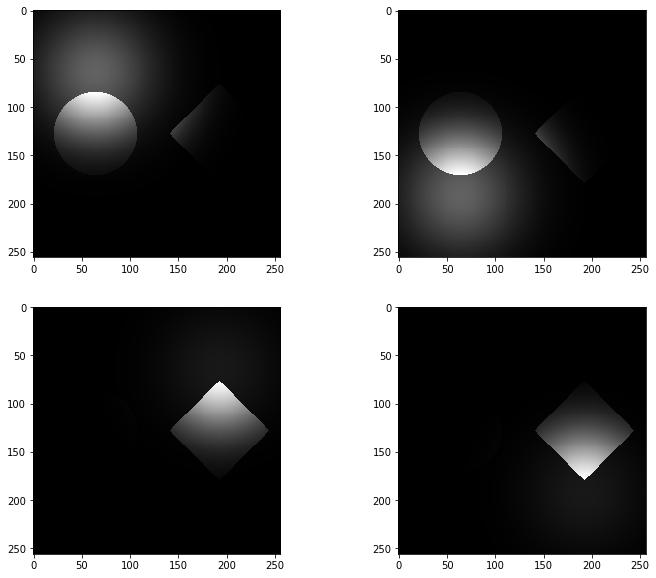

In [1]:
# -- Initialization
import numpy as np
import matplotlib.pyplot as plt
import mrsigpy as mrs
from scipy import signal as sig

%matplotlib inline

# -- Parameter Setup
print("Start")
Nx = 256     # Pixels along x
Ny = 256     # Pixels along y
Nc = 4       # Number of coils (channels)
x = np.arange(0,Nx)
y = np.arange(0,Ny)

# -- Generate image data
im = 10.0*mrs.diamond(width=Nx/2.5,nx=Nx,ny=Ny,cx=Nx/4.0) + mrs.circ(radius=Nx/6.0,nx=Nx,ny=Ny,cx=-Nx/4.0)*2.0

plt.figure(figsize=(12.,5.))
plt.subplot(1,3,1)
plt.imshow(im,cmap='gray',vmin=0.0,vmax=20.0)
plt.show

# -- Generate Coil Sensitivities
csens = np.zeros((Ny,Nx,Nc),dtype='complex64')
cx = np.array([0.25,0.75,0.25,0.75])
cy = np.array([0.25,0.25,0.75,0.75])
csc= np.array([1.2, 0.9, 0.75, 1.25])

for c in range(0,Nc):
  csens[:,:,c] = csc[c]*mrs.gaussian(x,Nx*cx[c],Nx/(1.5*Nc),y,Ny*cy[c],Ny/(1.5*Nc))

csens = csens / np.max(csens[:])

plt.subplot(1,3,2)
#plt.imshow(np.abs(csens[:,:,0]),cmap='gray')
plt.imshow(np.sum(np.abs(csens),axis=2), cmap='gray')
plt.title('Sensitivities')

plt.subplot(1,3,3)
plt.plot(x,csens[:,np.int(Ny/4),:],'b-')
plt.show

# -- Generate Coil Images
cims = csens * np.expand_dims(im,axis=2)

plt.figure(figsize=(12.,10.))
for c in range(Nc):
    plt.subplot(2,2,c+1)
    plt.imshow(abs(cims[:,:,c]),cmap='gray',vmin=0.0)
plt.show

print("cims pixel",cims[50,50,:])


## SENSE Reconstruction
1. Set reduction factor $R$.
1. Setup noise covariance matrix $\Psi$.
1. Re-organize sensitivities to include the aliased pixel dimpension in the last dimension, or 1 if $R=1$.


csens4calc intermediate shape is  (256, 1, 256, 4)
csens4calc shape is  (128, 256, 4, 2)
Image shape is  (128, 256)
SENSE Weight Calc - 32768 pts, 4 coils, R=2
Reshaped sensitivity size (32768, 4, 2)
Sense W matrix  [[ 9.48890635e+00+0.j -9.48890635e+00+0.j  1.17102395e-03+0.j
  -1.17102395e-03+0.j]
 [-1.17102395e-03+0.j  9.48890635e+00+0.j -1.44515820e-07+0.j
   1.17102395e-03+0.j]]
Sense W cum.    [[ 9.4889059e+00+0.j -9.4889059e+00+0.j  1.1710239e-03+0.j
  -1.1710239e-03+0.j]
 [-1.1710239e-03+0.j  9.4889059e+00+0.j -1.4451582e-07+0.j
   1.1710239e-03+0.j]]
Sense W matrix  [[ 9.16362537e+00+0.j -8.54143836e+00+0.j  1.13088138e-03+0.j
  -1.05409732e-03+0.j]
 [-1.21325848e-03+0.j  9.16362537e+00+0.j -1.49806231e-07+0.j
   1.13088130e-03+0.j]]
Sense W cum.    [[ 9.1636257e+00+0.j -8.5414381e+00+0.j  1.1308814e-03+0.j
  -1.0540973e-03+0.j]
 [-1.2132585e-03+0.j  9.1636257e+00+0.j -1.4980623e-07+0.j
   1.1308813e-03+0.j]]
SENSE weights has size (128, 256, 2, 4)
gfactor has size (256, 256)


<function matplotlib.pyplot.show(*args, **kw)>

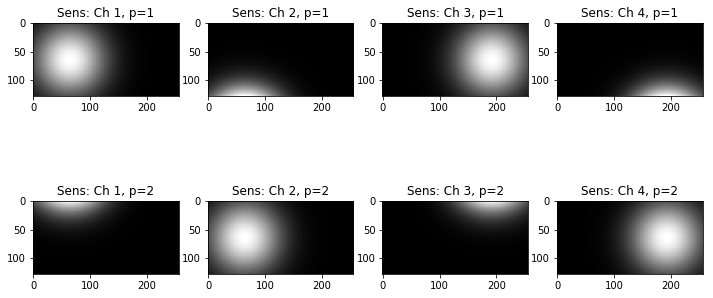

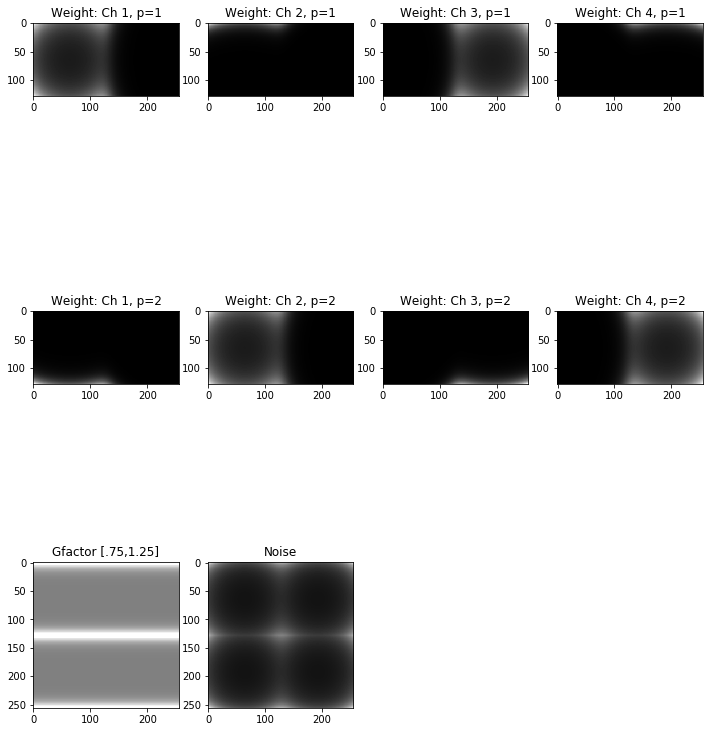

In [29]:
# -- Setup Full SENSE Problem
R = 2             # Reduction factor
Psi = np.eye(4)   # Noise covariance

# -- Coil Sensitivity for different R
#    As R increases, decrease FOV, but increase last dimension
csens = np.reshape(csens,(Ny,Nx,Nc,1),order='F')     # -- Make correct # dimensions (4)
csens4calc = np.moveaxis(csens,(0,1,2,3),(0,2,3,1))  # -- Bring R dimension next to Ny
print("csens4calc intermediate shape is ",csens4calc.shape)
csens4calc = np.reshape(csens4calc,(Ny//R,R,Nx,Nc),order='F')   # -- Assumes aliasing along Ny
csens4calc = np.moveaxis(csens4calc,(0,1,2,3),(0,3,1,2))  # -- Put R last again
print("csens4calc shape is ",csens4calc.shape)

# -- Plot rearranged sensitivities for debugging
if (1==1):
    plt.figure(figsize=(12.,2.0*(R+1)))
    for c in range(Nc):
        for r in range(R):
            plt.subplot(R,Nc,Nc*r+c+1)
            plotim = np.squeeze(abs(csens4calc[:,:,c,r]))
            plt.imshow(plotim,cmap='gray')
            tt = "Sens: Ch %d, p=%d" % (c+1,r+1)
            plt.title(tt)
        
        
(W,gfact,calcnoise) = mrs.senseweights(csens4calc, noisecov=Psi,gfactorcalc=True, noisecalc=True)

# -- Rearrange g-factor and noise matrices to display
gfact = np.moveaxis(gfact,(0,1,2),(0,2,1)) 
gfact = np.reshape(gfact,(Ny,Nx),order='F')
calcnoise = np.moveaxis(calcnoise,(0,1,2),(0,2,1)) 
calcnoise = np.reshape(calcnoise,(Ny,Nx),order='F')


print("SENSE weights has size",W.shape)
print("gfactor has size",gfact.shape)
print("calcnoise has size",calcnoise.shape)

plt.figure(figsize=(12.,5.0*(R+1)))
for c in range(Nc):
    for r in range(R):
        plt.subplot(R+1,Nc,Nc*r+c+1)
        plotim = np.squeeze(abs(W[:,:,r,c]))
        plt.imshow(plotim,cmap='gray')
        tt = "Weight: Ch %d, p=%d" % (c+1,r+1)
        plt.title(tt)
plt.subplot(R+1,Nc,R*Nc+1)
plt.imshow(np.squeeze(gfact),cmap='gray',vmin=0.75,vmax=1.25)
plt.title('Gfactor [.75,1.25]')
plt.subplot(R+1,Nc,R*Nc+2)
plt.imshow(np.squeeze(calcnoise),cmap='gray',vmin=0.0)
plt.title('Noise')
plt.show

## Reconstruct Images
Now we will reconstruct images using SENSE.  Steps are as follows:
1. Generate random, multivariate noise based on correlation matrix $\Psi$
2. Add noise to images, and alias the images based on reduction factor $R$
3. Reconstruct the images using SENSE
4. Repeat $N_{noise}$ times, saving images, then calculate histogram at various pixels for noise measure.
5. Compare noise measure with calculated noise.




Reconstructing 100 images (256 x 256) with 4 coils and R=2


/Users/brian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: ComplexWarning: Casting complex values to real discards the imaginary part


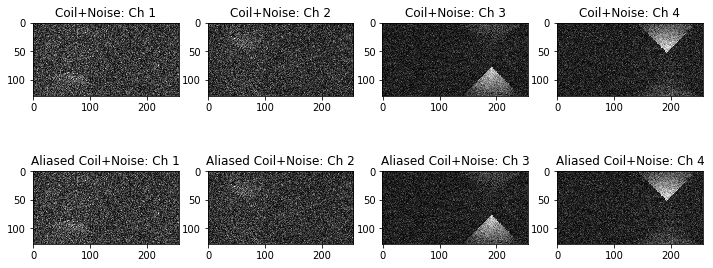

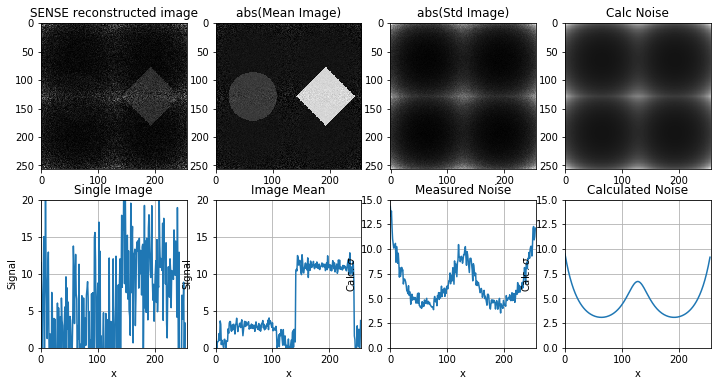

In [47]:
Nnoise = 100
imsall = np.zeros((Ny,Nx,Nnoise)) # -- To store multiple runs

plt.figure(figsize=(12.,5.0))
print("Reconstructing %d images (%d x %d) with %d coils and R=%d" % (Nnoise,Nx,Ny,Nc,R))
for n in range(Nnoise):
    # -- Generate random noise
    cnoise = np.random.multivariate_normal(np.zeros(Nc),Psi,(Ny*Nx)) + 1j*np.random.multivariate_normal(np.zeros(Nc),Psi,(Ny*Nx))
    cnoise = np.reshape(cnoise,(Ny,Nx,Nc),order='F')  # Ny x Nx x Nc 

    # -- Add noise cims = cims + cnoise
    cimsrecon = cims + cnoise
    
    # -- Alias the images
    cimsrecon = np.reshape(cimsrecon,(Ny,Nx,Nc,1))   # Add R dimension
    cimsrecon = np.moveaxis(cimsrecon,(0,1,2,3),(0,2,3,1))  # Move R in with Ny
    cimsrecon = np.reshape(cimsrecon,(Ny//R,R,Nx,Nc),order='F')  # Reshape to alias
    cimsrecon = np.squeeze(np.sum(cimsrecon,axis=1))   # Sum along R dimension and Squeeze (to alias!)
        
    # -- SENSE Reconstruction of noise only!
    sensesig = mrs.senserecon(cimsrecon,W)
    #print("sensesig size",sensesig.shape)
    
    # -- Combine unaliased FOVs
    sensesig = np.moveaxis(sensesig,(0,1,2),(0,2,1))    # -- Rearrange Ny x R x Nx
    sensesig = np.reshape(sensesig,(Ny,Nx),order='F')   # -- Concatenate FOVs
    
    imsall[:,:,n] = sensesig  # -- Accumulate all images
    
# -- Calculate mean / standard deviations of repeated reconstructions
sigmean = np.mean(imsall,axis=2)
sigstd = np.std(imsall,axis=2)

# -- Display output...

# -- Plot coil images from last run (debug)
for c in range(Nc):
    plt.subplot(2,Nc,c+1)
    plotim = np.squeeze(abs(cimsrecon[:,:,c]))
    plt.imshow(plotim,cmap='gray')
    tt = "Coil+Noise: Ch %d" % (c+1)
    plt.title(tt)
        
# -- Plot aliased images from last run (debug)
for c in range(Nc):
    plt.subplot(2,Nc,Nc+c+1)
    plotim = np.squeeze(abs(cimsrecon[:,:,c]))
    plt.imshow(plotim,cmap='gray')
    tt = "Aliased Coil+Noise: Ch %d" % (c+1)
    plt.title(tt)

# -- Show SENSE image
plt.figure(figsize=(12.,6.0))
plt.subplot(2,4,1)
plt.imshow(np.abs(sensesig),cmap='gray')
plt.title('SENSE reconstructed image')

plt.subplot(2,4,2)
plt.imshow(np.abs(sigmean),cmap='gray')
plt.title('abs(Mean Image)')

plt.subplot(2,4,3)
plt.imshow(np.abs(sigstd),cmap='gray')
plt.title('abs(Std Image)')

plt.subplot(2,4,4)
plt.imshow(np.squeeze(calcnoise),cmap='gray',vmin=0.0)
plt.title('Calc Noise')

# -- Plot lines of pixel values halfway down image.
plt.subplot(2,4,5)
plt.plot(x,np.squeeze(np.real(sensesig[Ny//2,:])))
mrs.lplot('x','Signal','Single Image',ax=(0,Nx,0,20))

plt.subplot(2,4,6)
plt.plot(x,np.squeeze(np.real(sigmean[Ny//2,:])))
mrs.lplot('x','Signal','Image Mean',ax=(0,Nx,0,20))

plt.subplot(2,4,7)
plt.plot(x,np.squeeze(np.abs(sigstd[Ny//2,:])))
mrs.lplot('x','Calc. $\sigma$','Measured Noise',ax=(0,Nx,0,15))

plt.subplot(2,4,8)
plt.plot(x,np.squeeze(calcnoise[Ny//2,:]))
mrs.lplot('x','Calc. $\sigma$','Calculated Noise',ax=(0,Nx,0,15))


## Results
### Notes:
1. Why is measured noise sqrt(2) higher than calculated noise?